In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

## 1. Read raw datacube and remove background & fringe

In [2]:
raw_datacube = Read_Raw_SITELLE_datacube("/home/qliu/data/A2390F/A2390SEC4.fits",name="A2390E")
wcs = WCS(raw_datacube.header, naxis=2)
raw_datacube.header

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 2064 / Axis length                                    
NAXIS3  =                  150 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2017-11-09T22:07:54' / Time of last modification                     
PROGRAM = 'ORB v3.1.2'         / Thomas Martin: thomas.martin.1@ulaval.ca       
DATE    = '2017-11-09T22:08:47' / Creation date                                 
MASK    = 'False   '                                                            
FILETYPE= 'Calibrated Spectr

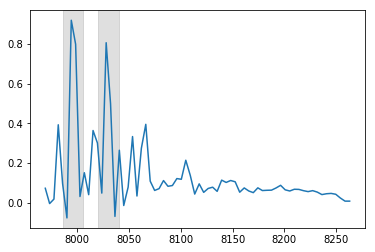

In [3]:
spec_med = [np.median(raw_datacube.raw_cube[k]) for k in range(len(raw_datacube.wavl))]
plt.axvspan(7986,8006,color='gray',alpha=0.25)
plt.axvspan(8020,8040,color='gray',alpha=0.25)
plt.plot(raw_datacube.wavl, spec_med)

In [4]:
raw_datacube.save_mask_edge(save_path = './proc/A2390E/')

Remove 2D background channel by channel.

In [3]:
raw_datacube.remove_background(box_size=128, save_path='./A2390SE/fig_iso/bkg/128/', plot=False)

Removing background... Channel: 10
Removing background... Channel: 20
Removing background... Channel: 30
Removing background... Channel: 40
Removing background... Channel: 50
Removing background... Channel: 60


In [4]:
raw_datacube.save_fits(save_path = './proc/A2390E/', suffix="_bgsub")

Saving processed datacube and stacked field...


Check stack field. Note the strong fringe pattern.

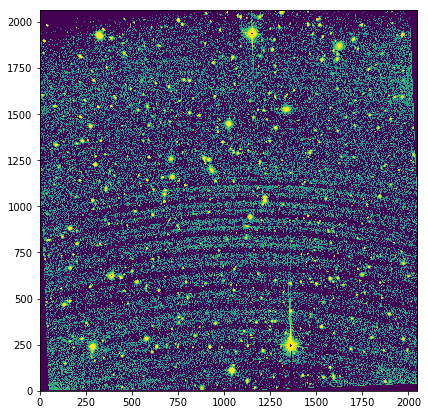

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(raw_datacube.stack_field, norm=norm1, vmin=0, vmax=3)

Note: Below compares two methods of removing fringes.

The first is an iterative detect-mask SE in small-scale. The second is a low-pass filtering by subtracting a smoothed image.

Take a channle, first subtract its large-scale background, and make mask map using stacked (background subtracted) cube.

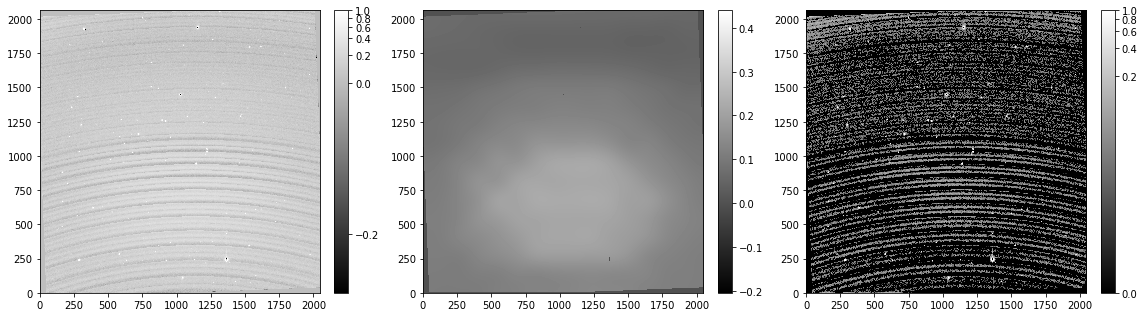

In [5]:
# background sub
field = raw_datacube.raw_cube[4]

back, back_rms = background_sub_SE(field, mask=raw_datacube.mask_edge,
                                   b_size=128, f_size=3, maxiters=10)
field_sub = field - back

fig = display_background_sub(field, back, vmax=1)

stack_field = raw_datacube.datacube_bkg_sub.sum(axis=0)
mask_source, segmap = make_mask_map(stack_field, sn_thre=3, b_size=128)
mask = (raw_datacube.mask_edge) | (mask_source)

Subtract fringes in two ways:

In [6]:
# fringe sub
# LPF
data_ma = field_sub.copy()
data_ma[mask] = 0
gau_kernel = Gaussian2DKernel(12,3)
lowpass = convolve(data_ma, gau_kernel, mask=mask)
lowpass[raw_datacube.mask_edge] = 0
highpass = field_sub - lowpass

# SE
back_fg, back_fg_rms = background_sub_SE(field_sub, mask=mask,
                                   b_size=16, f_size=1, maxiters=25)
field_sub_fg = field_sub - back_fg
back_fg[mask] = 0

Left: Masked data.  Right: Extracted fringes.

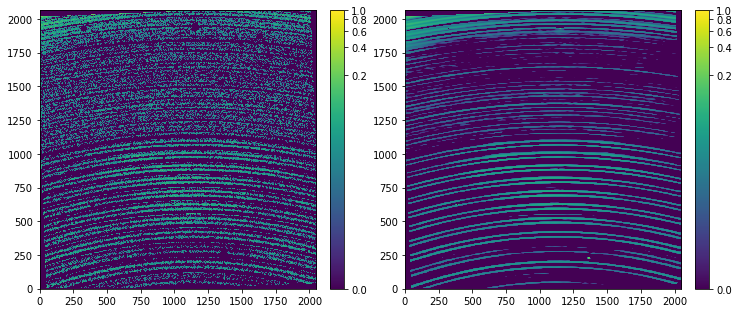

In [8]:
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(12,6))
im=ax1.imshow(data_ma, norm=norm1, origin="lower", vmin=0, vmax=1)
colorbar(im)
im=ax2.imshow(lowpass, norm=norm1, origin="lower", vmin=0, vmax=1)
colorbar(im)
plt.show()

Left: After LPF subtaction.  Right: After SE subtraction.

The LPF method is more homogeneous.

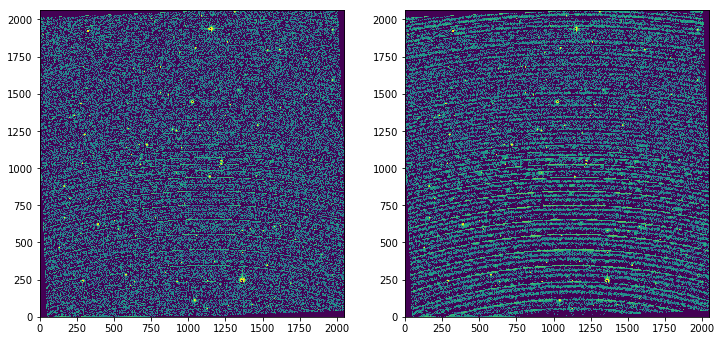

In [9]:
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(12,6))
ax1.imshow(highpass, norm=norm1, origin="lower", vmin=0, vmax=1)
ax2.imshow(field_sub_fg, norm=norm1, origin="lower", vmin=0, vmax=1)
plt.show()

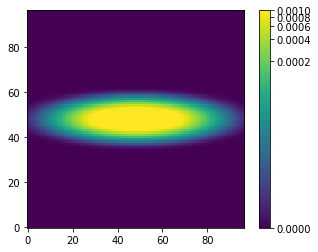

In [10]:
im=plt.imshow(Gaussian2DKernel(12,3), norm=norm1, origin="lower", vmin=0, vmax=1e-3)
colorbar(im)

Zoom-in to see the difference:

In [11]:
def zoom_compare_fringe(x, y):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,10))
    i, j = y, x
    
    img_list = [field_sub, highpass, lowpass, stack_field, field_sub_fg, back_fg]
    for ax, img in zip([ax1,ax2,ax3,ax4,ax5,ax6],img_list):
        vmax, vmin = (1,0) if img is stack_field else (0.1,-0.1)
        im = ax.imshow(img[i-50:i+51, j-50:j+51], origin="lower", vmin=vmin, vmax=vmax)
        colorbar(im)
        
    ax1.set_title("Background subtracted channel")
    ax2.set_title("After Low-pass Filtering")
    ax3.set_title("Low-pass Filtered (12,4)")
    ax4.set_title("Stack Field")
    ax5.set_title("After SE 16x16")
    ax6.set_title("SE mode 16x16")
    plt.show()
    
x, y = 1121,892
x, y = 426,1044
x, y = 670,1084

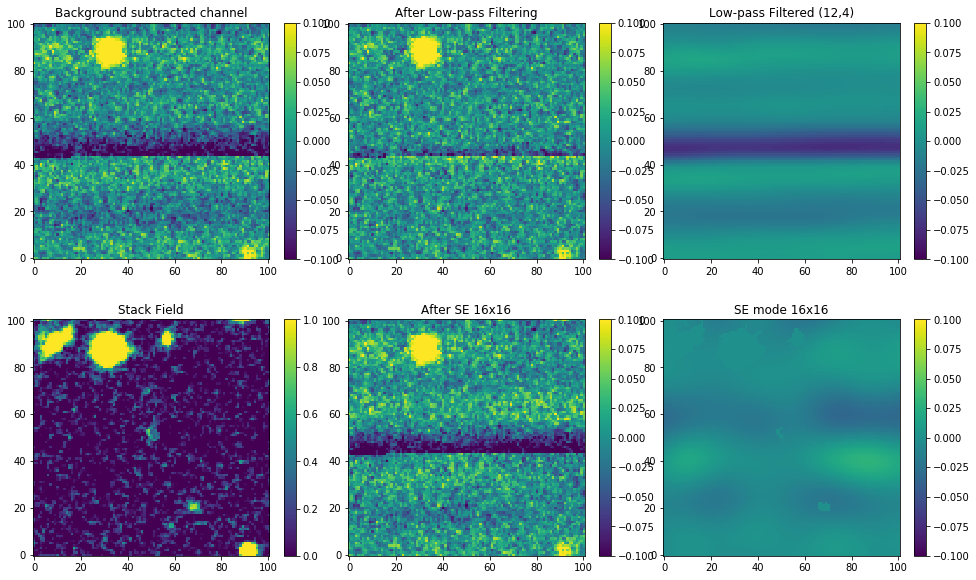

In [12]:
zoom_compare_fringe(1090, 1250)

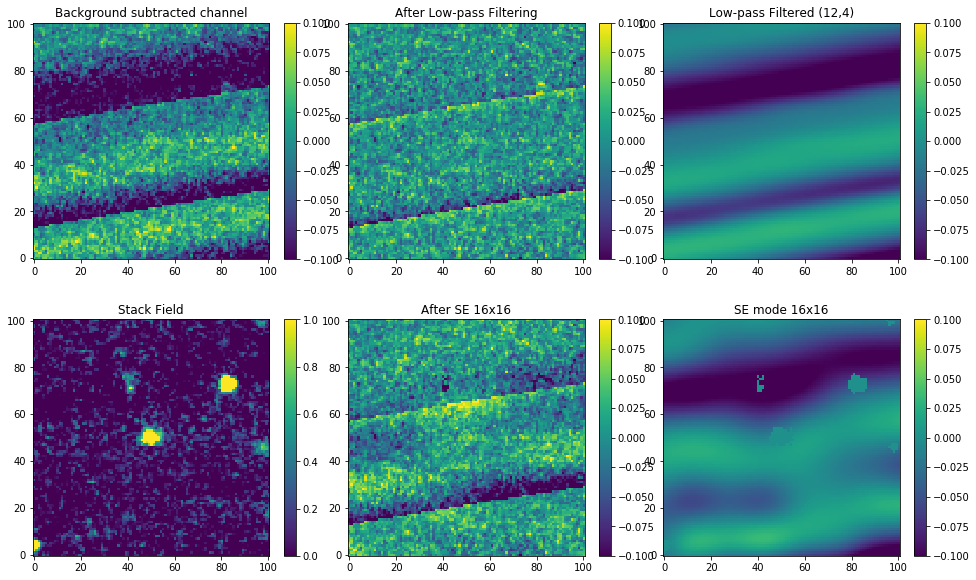

In [13]:
zoom_compare_fringe(426,1044)

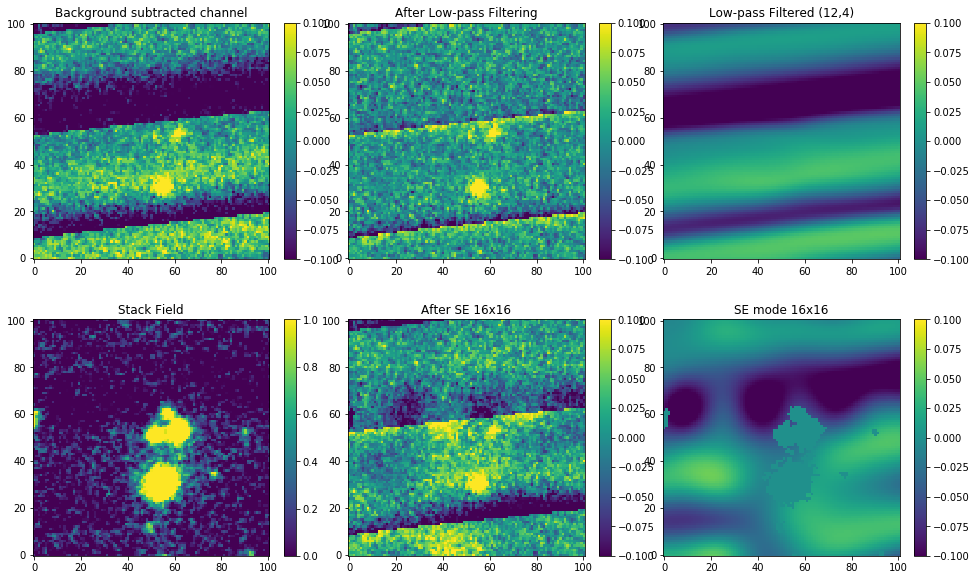

In [14]:
zoom_compare_fringe(670,1084)

Looking at some specific channels which suffer most.

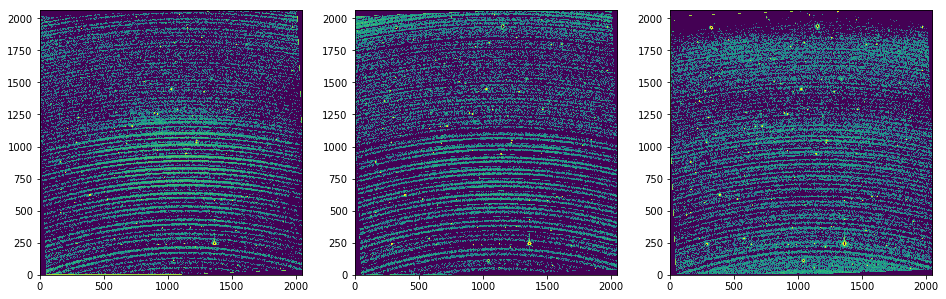

In [15]:
fig, axes = plt.subplots(1,3,figsize=(16,5))
for i, ax in zip([3,4,5], axes):
    ax.imshow(raw_datacube.datacube_bkg_sub[i], norm=norm1, origin="lower", vmin=0, vmax=1)

Looking at a few spaxels before and after subtraction:

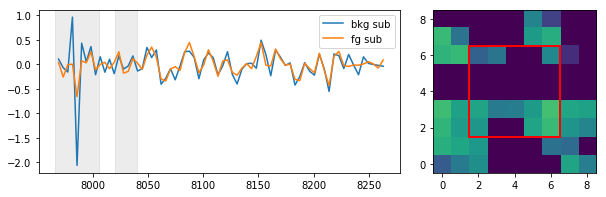

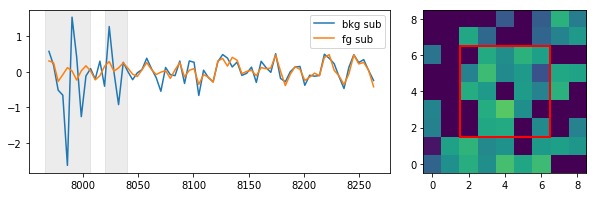

In [18]:
inspec_spaxel(1000,800, raw_datacube)
inspec_spaxel(1000,22, raw_datacube)

RA DEC : 328.5586, 17.5392


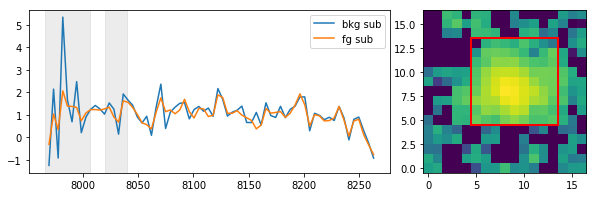

RA DEC : 328.4595, 17.5454


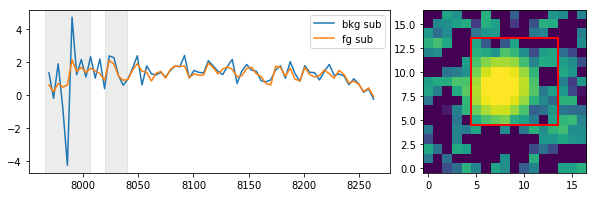

RA DEC : 328.5353, 17.5427


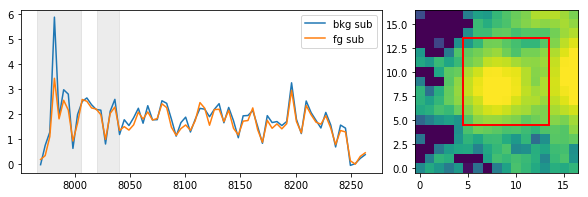

RA DEC : 328.5344, 17.5427


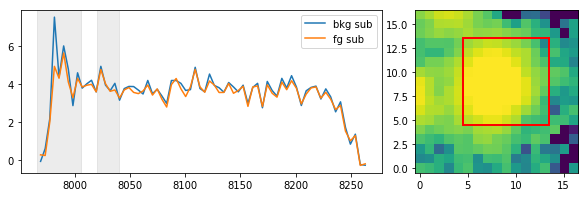

RA DEC : 328.4930, 17.5248


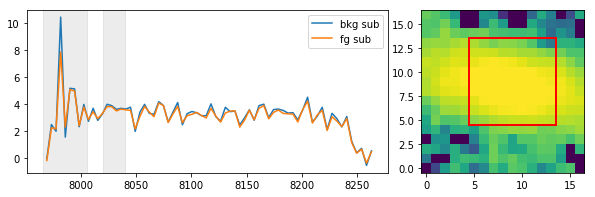

In [19]:
inspec_spaxel(425, 1044, raw_datacube, w=4, wcs=wcs)
inspec_spaxel(1472,1124, raw_datacube, w=4, wcs=wcs)
inspec_spaxel(672,1085, raw_datacube, w=4, wcs=wcs) # This is a lower-z SII line
inspec_spaxel(682,1086, raw_datacube, w=4, wcs=wcs) # This is a lower-z SII line
inspec_spaxel(1121,892, raw_datacube, w=4, wcs=wcs) # This is a lower-z SII line

RA DEC : 328.4789, 17.4829


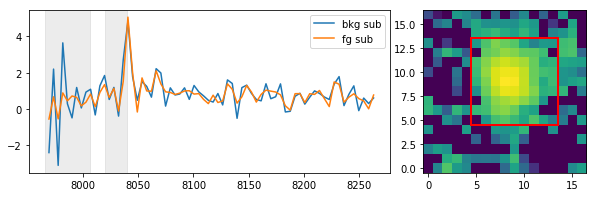

RA DEC : 328.4213, 17.4978


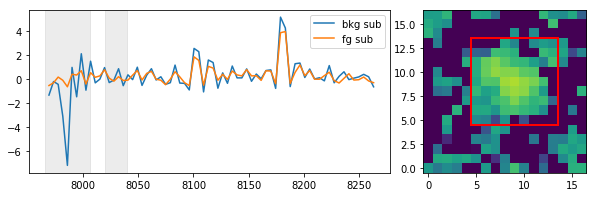

RA DEC : 328.5397, 17.5199


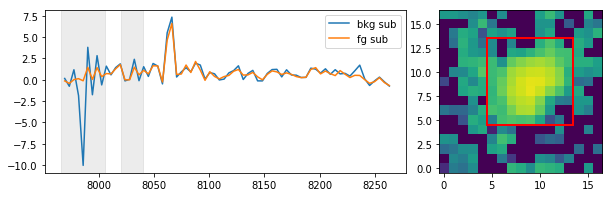

RA DEC : 328.5407, 17.5211


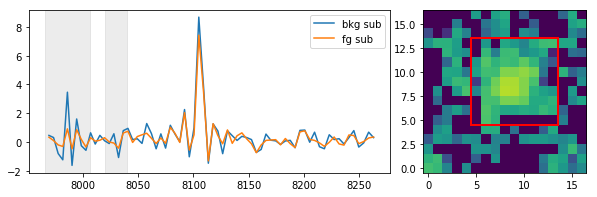

RA DEC : 328.4955, 17.5572


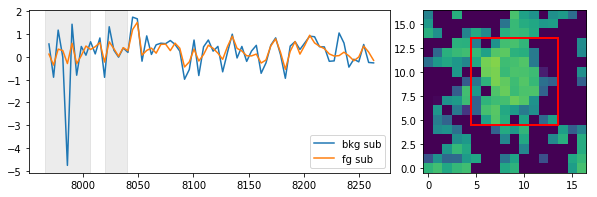

In [20]:
inspec_spaxel(1275,428, raw_datacube, w=4, wcs=wcs)
inspec_spaxel(1888,597, raw_datacube, w=4, wcs=wcs)
inspec_spaxel(628,832, raw_datacube, w=4, wcs=wcs)
inspec_spaxel(617,845, raw_datacube, w=4, wcs=wcs)
inspec_spaxel(1090, 1250, raw_datacube, w=4, wcs=wcs)

Do fringe subtraction:

In [17]:
channels,_ = raw_datacube.get_channel()
raw_datacube.remove_fringe(channels, k_size=(12,3), sn_source=3, method='LPF',
                           save_path='./A2390SE/fig_iso/bkg/LPF/',
                           parallel=True, verbose=True, clear=True, plot=True)

./A2390SE/fig_iso/bkg/LPF/ exists. Remove all the content.
Run iteration to clean fringes for channels: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
'
Run low-pass filtering in parallel. Used when run on >20 channels.
Iteration 1 : 0 sources detected.
Iteration 2 : 1436 sources detected.

Iteration finished.


After fringe subtraction:

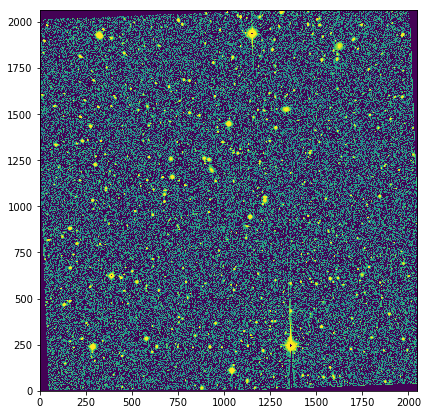

In [21]:
plt.figure(figsize=(7,7))
plt.imshow(raw_datacube.stack_field, norm=norm1, vmin=0, vmax=3)

In [22]:
raw_datacube.save_weight_map(region_path="./A2390SE/A2390SE.reg", weight=0.001, save_path = './proc/A2390E/')

In [23]:
raw_datacube.save_fits(save_path = './proc/A2390E/', suffix="_lpf")

Saving processed datacube and stacked field...


## 2. Extract source and spectra from datacube 

In [13]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube_bgsub.fits', z0=0.228, name='A2390E',
                         cube_supplementary='./proc/A2390E/A2390E_cube_lpf.fits',
                         wavl_mask=[[7950,8006],[8020,8040], [8230,8280]],
                         mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits', mode="MMA")

[[7950, 8006], [8020, 8040], [8230, 8280]]  are affected by edge / fringes.


In [3]:
src_map, seg_map = datacube.ISO_source_detection(sn_thre=3, nlevels=64, contrast=0.01, 
                                                 b_size=128, box=[3,3,5], closing=False, 
                                                 save=True, save_path = './proc/A2390E/', suffix="_lpf")

Use the map of maximum of moving average (MMA) to detect source.
Box shape:  [3, 3, 5]
Detecting and deblending source...
Finish. Saved as ./proc/A2390E/A2390E_MMA_lpf.dat


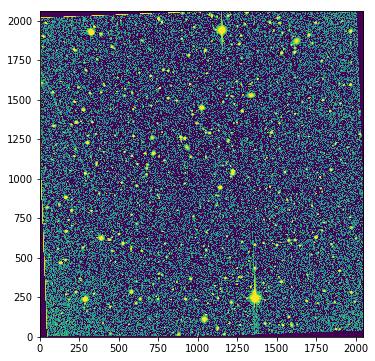

In [4]:
plt.figure(figsize=(6,6))
plt.imshow(datacube.src_map, norm=norm1, vmin=np.median(datacube.src_map),
           vmax=np.median(datacube.src_map)+20*mad_std(datacube.src_map))

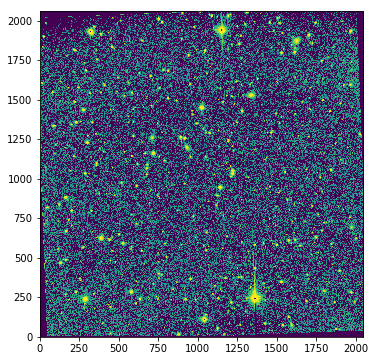

In [5]:
plt.figure(figsize=(6,6))
plt.imshow(datacube.stack_field, norm=norm1, vmin=np.median(datacube.stack_field),
           vmax=np.median(datacube.stack_field)+20*mad_std(datacube.stack_field))

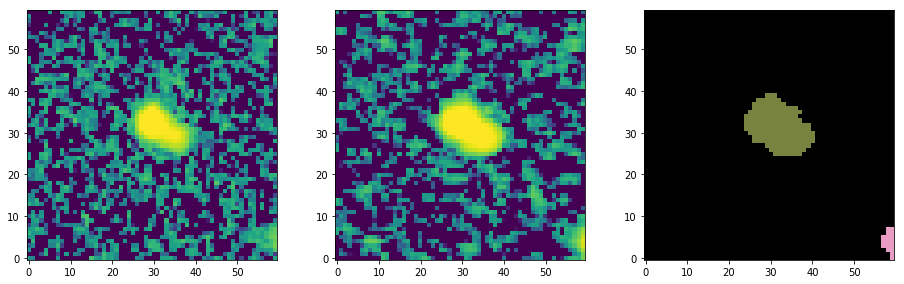

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
im1 = ax1.imshow(datacube.stack_field[240:300, 1060:1120], norm=norm1, vmin=np.median(datacube.stack_field),
           vmax=np.median(datacube.stack_field)+20*mad_std(datacube.stack_field))
im2 = ax2.imshow(datacube.src_map[240:300, 1060:1120], norm=norm2, vmin=np.median(datacube.src_map),
           vmax=np.median(datacube.src_map)+20*mad_std(datacube.src_map))
im3 = ax3.imshow(seg_map[240:300, 1060:1120], origin="lower", cmap=rand_cmap) 
plt.tight_layout()

In [7]:
datacube.ISO_spec_extraction_all(seg_map)

Extract spectra... 400/1661
Extract spectra... 800/1661
Extract spectra... 1200/1661
Extract spectra... 1600/1661


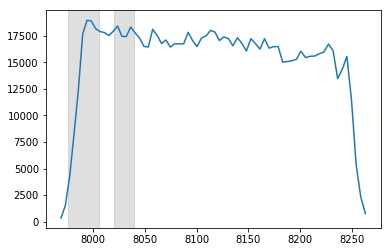

In [27]:
plt.plot(datacube.wavl, datacube.spec_stack)
plt.axvspan(7976,8006,color='gray',alpha=0.25)
plt.axvspan(8020,8040,color='gray',alpha=0.25)

In [8]:
datacube.fit_continuum_all(model='GP', plot=True, save_path='./A2390SE/fig_iso/fit_cont_MMA_lpf/', edge_ratio=0.1)

./A2390SE/fig_iso/fit_cont_MMA_lpf/ exists. Remove all the content.
Fit spectra continuum ... 400/1661
Fit spectra continuum ... 800/1661
Fit spectra continuum ... 1200/1661
Fit spectra continuum ... 1600/1661
Skip spurious detection:  #1493 #1527 #1579 #1596 #1621 #1623 #1629 #1638 #1639 #1640 #1641 #1642 #1643 #1644 #1645 #1647 #1648 #1649 #1650 #1651 #1652 #1653 #1655 #1656 #1657 #1658 #1660 #1661  ... Replaced with random noise.
Continuum Fitting Finished!


In [11]:
datacube.save_spec_fits(save_path='./proc/A2390E', suffix="_lpf_all")

## 3. Generate Templates

In [1]:
from pipeline import *
from utils import *

In [350]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube.fits', 
                         name='A2390E', z0=0.228, mode="MMA")

In [3]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2, 
                           temp_type="OII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.), 
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='gauss')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8),
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='gauss')

Template: OII_gauss  Total Number: 10
Template: Hb-OIII_gauss  Total Number: 80
Template: Ha-NII_gauss  Total Number: 400


In [4]:
datacube.generate_template(n_ratio=1, n_stddev=10, n_intp=2,
                           temp_type="OII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=8, n_stddev=10, n_intp=2, ratio_range = (2., 4.),
                           temp_type="Hb-OIII", ratio_prior="log-uniform", temp_model='box')
datacube.generate_template(n_ratio=40, n_stddev=10, n_intp=2, ratio_range = (1., 8), 
                           temp_type="Ha-NII", ratio_prior="log-uniform", temp_model='box')

Template: OII_box  Total Number: 1
Template: Hb-OIII_box  Total Number: 8
Template: Ha-NII_box  Total Number: 40


In [5]:
for mod in ['gauss','box']:
    for typ in ["Ha-NII", "Hb-OIII", "OII"]:
        datacube.Save_Template(save_path='./proc/template/', temp_type=typ, temp_model=mod)

Save A2390E templates for Ha-NII_gauss as Template-A2390E_Ha-NII_gauss.fits
Save A2390E templates for Hb-OIII_gauss as Template-A2390E_Hb-OIII_gauss.fits
Save A2390E templates for OII_gauss as Template-A2390E_OII_gauss.fits
Save A2390E templates for Ha-NII_box as Template-A2390E_Ha-NII_box.fits
Save A2390E templates for Hb-OIII_box as Template-A2390E_Hb-OIII_box.fits
Save A2390E templates for OII_box as Template-A2390E_OII_box.fits


## 4. Cross-correlation

In [1]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [14]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube_lpf.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         table='./proc/A2390E/A2390E_MMA_lpf.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA_lpf.fits')

datacube.read_spec('./proc/A2390E/A2390E-spec-MMA_lpf_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390E')

Read Emission Line Template:
['./proc/template/Template-A2390E_Ha-NII_gauss.fits',
 './proc/template/Template-A2390E_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390E_OII_gauss.fits',
 './proc/template/Template-A2390E_Ha-NII_box.fits',
 './proc/template/Template-A2390E_Hb-OIII_box.fits',
 './proc/template/Template-A2390E_OII_box.fits']


Detection #62  z: 0.229  sigma: 3.115  Peak R: 2.245  Detction S/N: 25.791 Peak S/N: 12.390


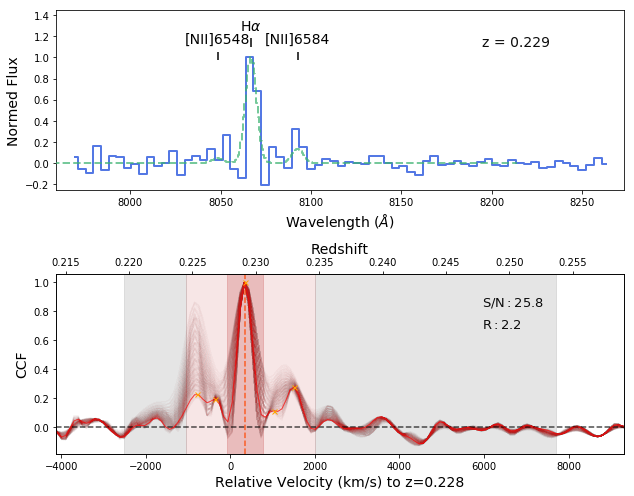

In [39]:
result = datacube.cross_correlation(62, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

Detection #82  z: 0.228  sigma: 1.834  Peak R: 3.101  Detction S/N: 5.279 Peak S/N: 5.272


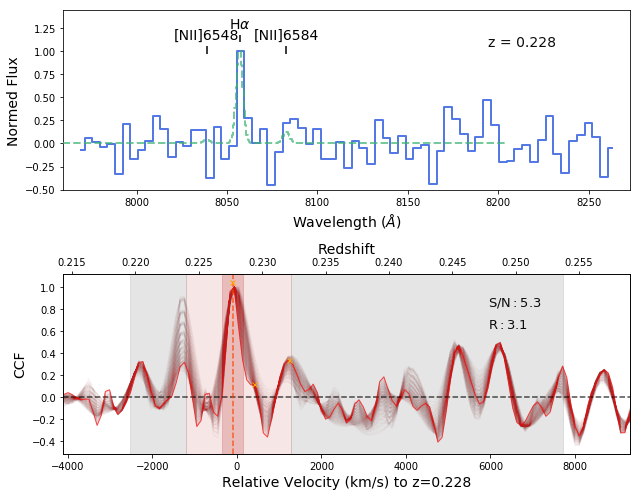

In [40]:
result = datacube.cross_correlation(82, temp_type="Ha-NII", edge=20, const_window=False, temp_model="gauss")

In [22]:
datacube.cross_correlation_all(temp_type="Ha-NII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="Hb-OIII", temp_model="gauss", edge=20, verbose=False)
datacube.cross_correlation_all(temp_type="OII", temp_model="gauss", edge=20, verbose=False)

Do cross-correlation using Ha-NII_gauss model templates...
Do cross-correlation using Hb-OIII_gauss model templates...
Do cross-correlation using OII_gauss model templates...


In [23]:
datacube.save_cc_result(save_path='./proc/A2390E/', suffix="_lpf")

Save cross-correlation results for A2390E as : ./proc/A2390E/A2390E-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


## 5. Select Candidate

In [2]:
from pipeline import *
from utils import *
%load_ext autoreload
%autoreload 2

In [3]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube_lpf.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         wavl_mask=[[7950,8006],[8020,8040], [8230,8280]],
                         table='./proc/A2390E/A2390E_MMA_lpf.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA_lpf.fits',
                         mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits')

datacube.deep_frame =  fits.open('./proc/A2390E/A2390E_DF.fits')[0].data
datacube.src_map = fits.open('./proc/A2390E/A2390E_MMA_lpf.fits')[0].data
datacube.read_spec('./proc/A2390E/A2390E-spec-MMA_lpf_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390E')
datacube.read_cc_result('./proc/A2390E/A2390E-cc-MMA_lpf.pkl')

Read Emission Line Template:
['./proc/template/Template-A2390E_Ha-NII_gauss.fits',
 './proc/template/Template-A2390E_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390E_OII_gauss.fits',
 './proc/template/Template-A2390E_Ha-NII_box.fits',
 './proc/template/Template-A2390E_Hb-OIII_box.fits',
 './proc/template/Template-A2390E_OII_box.fits']
Read cross-correlation results for A2390E from : ./proc/A2390E/A2390E-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


In [4]:
SNR_best_Ha_gauss = datacube.get_CC_result_best('SNR', 'Ha-NII_gauss')
SNR_best_OIII_gauss = datacube.get_CC_result_best('SNR', 'Hb-OIII_gauss')
SNR_best_OII_gauss = datacube.get_CC_result_best('SNR', 'OII_gauss')

z_best_OIII_gauss = datacube.get_CC_result_best('z_best', 'Hb-OIII_gauss')
flag_e_Ha_gauss = datacube.get_CC_result_best('flag_e', 'Ha-NII_gauss')

### Match with SDSS stars

In [5]:
cat_match = datacube.match_sdss_star(sep=3*u.arcsec, search_radius=7*u.arcmin, band='rmag')

c_match_star = SkyCoord(ra=cat_match["RA_ICRS"], dec=cat_match["DE_ICRS"])
star_match_pos = np.array(c_match_star.to_pixel(datacube.wcs, origin=0)).T

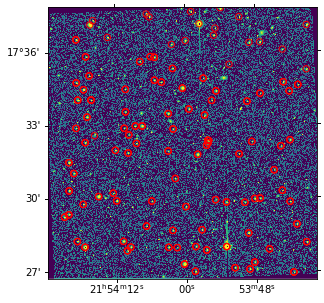

In [7]:
plt.figure(figsize=(5,5))
ax = plt.subplot(projection=datacube.wcs)
plt.scatter(star_match_pos[:,0], star_match_pos[:,1], s=40, facecolor="none", edgecolor="r")
plt.imshow(datacube.stack_field, norm=norm1, vmin=np.median(datacube.stack_field), vmax=10)

### Measure distance

In [8]:
dist_to_edge = measure_dist_to_edge(datacube.table, datacube.mask_edge, pad=200)

### Measure EW

(8.770333932250086, 8.327750034331887)

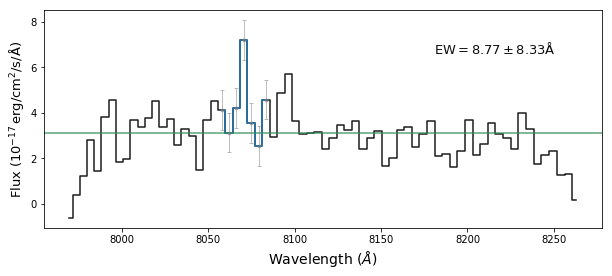

In [87]:
datacube.estimate_EW(3, MC_err=True)

(17.596096114584537, 17.032957465657503)

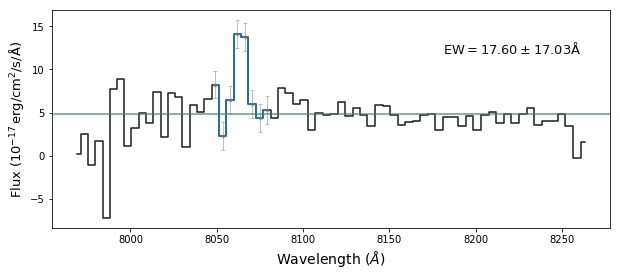

In [88]:
datacube.estimate_EW(1, MC_err=True)

In [9]:
datacube.estimate_EW_all(MC_err=True)

Measure EW... 400/1661
Measure EW... 800/1661
Measure EW... 1200/1661
Measure EW... 1600/1661


In [10]:
bad_channel,_ = datacube.get_channel([[7950,8006],[8020,8040], [8230,8280]])
max_channel = np.argmax(datacube.obj_specs_opt, axis=1) + 1
strong_sky = np.array([max_ch in bad_channel for max_ch in max_channel])
low_cont = np.median(datacube.obj_specs_opt, axis=1) < 0.1
good_line = ~(strong_sky & low_cont) #& (max_channel==4)

### Conditions

In [12]:
EW_cond = (datacube.EWs > datacube.EW_stds) & (datacube.EWs > 5)
edge_cond = dist_to_edge > 5

SNR_min_gauss = np.min([SNR_best_Ha_gauss, SNR_best_OIII_gauss, SNR_best_OII_gauss], axis=0)

SNR_cond_A = (SNR_best_Ha_gauss > 10) & (SNR_best_OII_gauss>3)
SNR_cond_B = (SNR_best_Ha_gauss > 5) & (SNR_best_Ha_gauss <= 10) & (SNR_best_OII_gauss>5)

zmin_OIII = datacube.wavl.min()/4959-1
# SN OIII > 5, SN OIII > SN Ha, SN OIII > SN OII 
SNR_cond_C = (SNR_best_OIII_gauss > np.max([5*np.ones_like(datacube.obj_nums), SNR_best_Ha_gauss], axis=0)) \
            & (SNR_best_OII_gauss>3) & (z_best_OIII_gauss>zmin_OIII)

save = True
for v in ['A', 'B', 'C']:
    SN_cond_v = {'A':SNR_cond_A, 'B':SNR_cond_B, 'C':SNR_cond_C}
    type_v = {'A':"Ha-NII", 'B':"Ha-NII", 'C':"Hb-OIII"}

    num_c = datacube.obj_nums[EW_cond & SN_cond_v[v] & edge_cond & good_line]

    # remove stars and possible artifacts
    num_c = np.setdiff1d(num_c, np.concatenate([cat_match["NUMBER"].data, datacube.num_spurious]))
    print("%s: %d candidates:"%(v,len(num_c)), num_c)

    if save:
        save_path = './A2390SE/fig_iso/candidate_lpf/%s'%v
        check_save_path(save_path, clear=True)
        for k, num in enumerate(num_c):
            if np.mod(k+1, 25)==0: print("Plot: %d/%d"%(k+1, len(num_c)))
            datacube.plot_candidate(num, temp_type=type_v[v], temp_model="gauss")
            plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)
            plt.close()
if save:            
    check_save_path('./A2390SE/fig_iso/candidate_lpf/V')

A: 34 candidates: [  14   49   79   99  134  184  216  252  262  297  323  367  375  604
  607  616  639  916  929 1018 1098 1141 1311 1365 1410 1442 1489 1495
 1512 1518 1594 1595 1637 1659]
./A2390SE/fig_iso/candidate_lpf/A does not exist. Make a new directory.
Plot: 25/34
B: 58 candidates: [  38   47   77  109  113  128  159  180  206  233  248  258  293  315
  341  344  351  358  386  389  435  438  465  553  558  631  642  691
  719  743  762  902  939 1006 1059 1069 1089 1102 1135 1185 1188 1189
 1210 1220 1256 1258 1274 1297 1326 1398 1418 1427 1453 1558 1586 1592
 1601 1630]
./A2390SE/fig_iso/candidate_lpf/B does not exist. Make a new directory.
Plot: 25/58
Plot: 50/58
C: 24 candidates: [ 293  354  435  517  553  652  699  719  762  780  986 1006 1021 1089
 1185 1209 1220 1239 1285 1347 1427 1513 1586 1601]
./A2390SE/fig_iso/candidate_lpf/C does not exist. Make a new directory.
./A2390SE/fig_iso/candidate_lpf/V does not exist. Make a new directory.


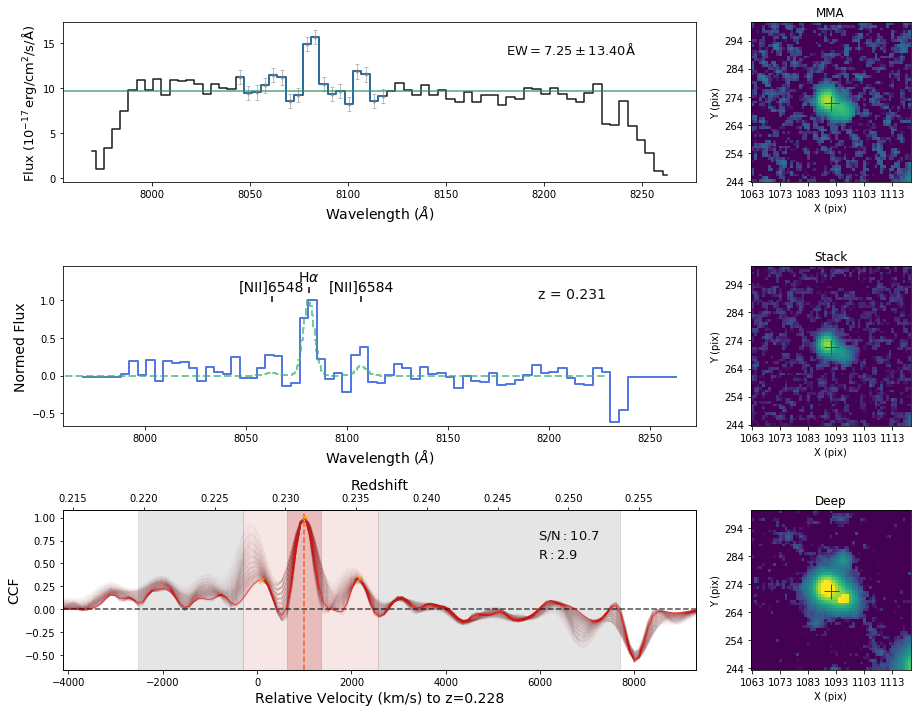

In [92]:
save_path = './A2390SE/fig_iso/candidate/V'
num = 147
datacube.plot_candidate(num, temp_type=type_v[v], temp_model="gauss")
# plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)

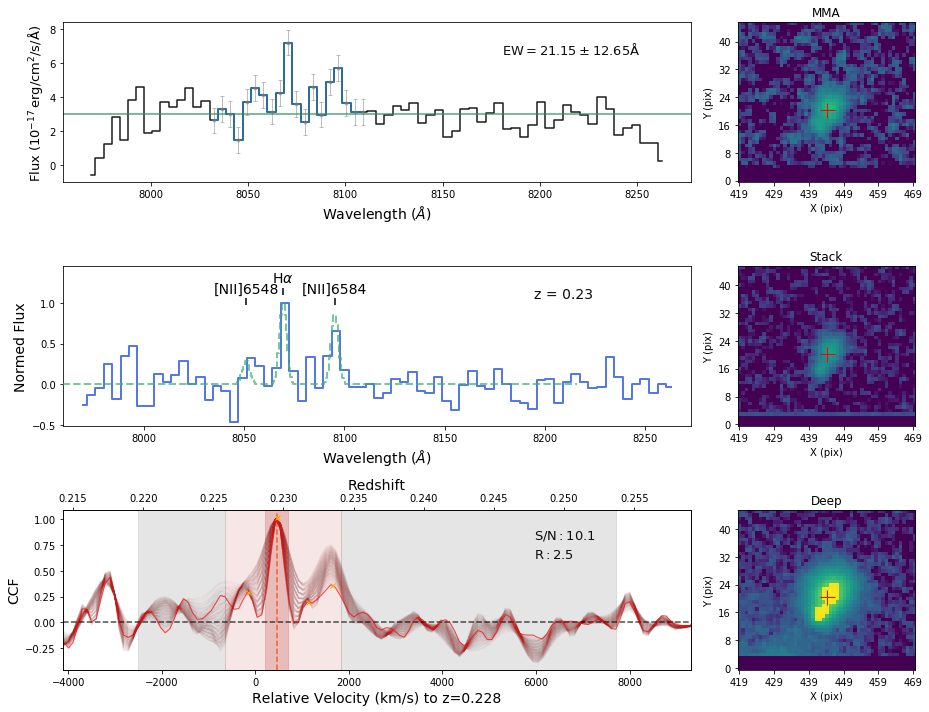

In [60]:
save_path = './A2390SE/fig_iso/candidate/V'
num = 3
datacube.plot_candidate(num, temp_type=type_v[v], temp_model="gauss")
# plt.savefig(os.path.join(save_path, "#%d.png"%num),dpi=75)

## 6. Measure Centroid

In [1]:
from pipeline import *
from utils import *

%load_ext autoreload
%autoreload 2

In [2]:
datacube = Read_Datacube('./proc/A2390E/A2390E_cube_bgsub.fits', 
                         name='A2390E', z0=0.228, mode="MMA",
                         table='./proc/A2390E/A2390E_MMA_lpf.dat', 
                         seg_map='./proc/A2390E/A2390E_segm_MMA_lpf.fits',
                         deep_frame='./proc/A2390E/A2390E_DF.fits',
                         mask_edge='./proc/A2390E/Raw_stack_A2390E_mask.fits')
datacube.get_wcs()
datacube.src_map = fits.open('./proc/A2390E/A2390E_MMA_lpf.fits')[0].data
datacube.read_spec('./proc/A2390E/A2390E-spec-MMA_lpf_all.fits')
datacube.Read_Template('./proc/template/', n_intp=2, name='A2390E')
datacube.read_cc_result('./proc/A2390E/A2390E-cc-MMA_lpf.pkl')

Read Emission Line Template:
['./proc/template/Template-A2390E_Ha-NII_gauss.fits',
 './proc/template/Template-A2390E_Hb-OIII_gauss.fits',
 './proc/template/Template-A2390E_OII_gauss.fits',
 './proc/template/Template-A2390E_Ha-NII_box.fits',
 './proc/template/Template-A2390E_Hb-OIII_box.fits',
 './proc/template/Template-A2390E_OII_box.fits']
Read cross-correlation results for A2390E from : ./proc/A2390E/A2390E-cc-MMA_lpf.pkl
Template used: ['Ha-NII_gauss', 'Hb-OIII_gauss', 'OII_gauss']


In [3]:
el_C = glob.glob("./A2390SE/fig_iso/candidate_lpf/C/#*.png")
Num_b = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_C]).astype("int"))
Num_b

array([ 293,  435,  762, 1427, 1586])

In [4]:
el_v = glob.glob("./A2390SE/fig_iso/candidate_lpf/V/#*.png")
Num_v_all = np.sort(np.array([re.compile(r'\d+').findall(el)[-1] for el in el_v]).astype("int"))
print(Num_v_all)

z_V =  datacube.get_CC_result_best('z_best', 'Ha-NII_gauss', Num_v_all)

[  14   38   47   77   79   99  109  128  134  184  206  216  233  248
  252  258  262  293  297  315  323  341  344  351  358  367  375  386
  435  438  465  553  558  604  607  616  631  639  642  691  719  743
  762  902  916  929  939 1006 1018 1059 1069 1089 1098 1141 1188 1210
 1274 1365 1410 1427 1442 1453 1489 1495 1512 1518 1586 1592 1594 1595
 1601 1630 1637]


In [5]:
datacube.assign_BCG_coordinate((328.40351201,17.69544013))
X_BCG, Y_BCG = datacube.wcs.all_world2pix(datacube.coord_BCG.ra, datacube.coord_BCG.dec, 0)
datacube.pos_BCG = (X_BCG, Y_BCG)

BCG coordinate:  21h53m36.8429s +17d41m43.5845s


Error of light-wighted centroid: $\sigma_{\left<x\right>} = \Sigma_j \frac{\sigma^2_{I_j} \cdot (x_j-\left<x\right>)^2}{\Sigma_i I_i^2}$

http://ugastro.berkeley.edu/infrared09/PDF-2009/centroid-error.pdf

In [7]:
for sn in [2.0,2.5]:
    datacube.result_centroid = {}
    
    save_path = './proc/A2390E/Centroid_weighted_sn%.1f'%sn
    check_save_path(save_path, clear=True)
    for num in np.setdiff1d(Num_v_all, Num_b):
        res = datacube.centroid_analysis(num, centroid_type="ISO-D", sum_type='weighted',
                                         sn_thre=sn, smooth=False, verbose=False)
        if len(res) > 0:
            plt.savefig(os.path.join(save_path, '#%dE.png'%num), dpi=75)
            plt.close()
            
    datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", 
                                   sn_thre=sn, sum_type='weighted', morph_cen=False, verbose=False, smooth=False)
    datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D",
                                   sn_thre=sn, sum_type='weighted', morph_cen=True, verbose=False, smooth=False)
#     if sn==2.5:
#         datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", 
#                                        sn_thre=sn, sum_type='mean', morph_cen=False, verbose=False, smooth=True)
#         datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D",
#                                        sn_thre=sn, sum_type='mean', morph_cen=True, verbose=False, smooth=True)
    
    datacube.save_centroid_measurement(Num_v_all, ID_field='E', suffix="_weighted_sn%.1f"%sn, save_path='./proc/')

./proc/A2390E/Centroid_weighted_sn2.0 does not exist. Make a new directory.


/home/qliu/anaconda3/lib/python3.7/site-packages/photutils-0.8.dev3883-py3.7-linux-x86_64.egg/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]
/home/qliu/anaconda3/lib/python3.7/site-packages/photutils-0.8.dev3883-py3.7-linux-x86_64.egg/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]


Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E_weighted_sn2.0.txt
./proc/A2390E/Centroid_weighted_sn2.5 does not exist. Make a new directory.


/home/qliu/anaconda3/lib/python3.7/site-packages/photutils-0.8.dev3883-py3.7-linux-x86_64.egg/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]


Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E_weighted_sn2.5.txt


stddev emission: 0.011 / continuum: 0.004
Centroid EM: (477.00+/-0.58, 1013.00+/-0.58)
Centroid CON: (480.29+/-0.02, 1013.44+/-0.02)


{'diff_angle': 40.439248537579374,
 'cen_offset': 3.3223986121324316,
 'diff_angle_std': 10.082027451715359,
 'cen_offset_std': 0.5845965203572938,
 'pa': 277.6358135565779,
 'clus_cen_angle': 318.07506209415726,
 'dist_clus_cen': 2392.8325085176352}

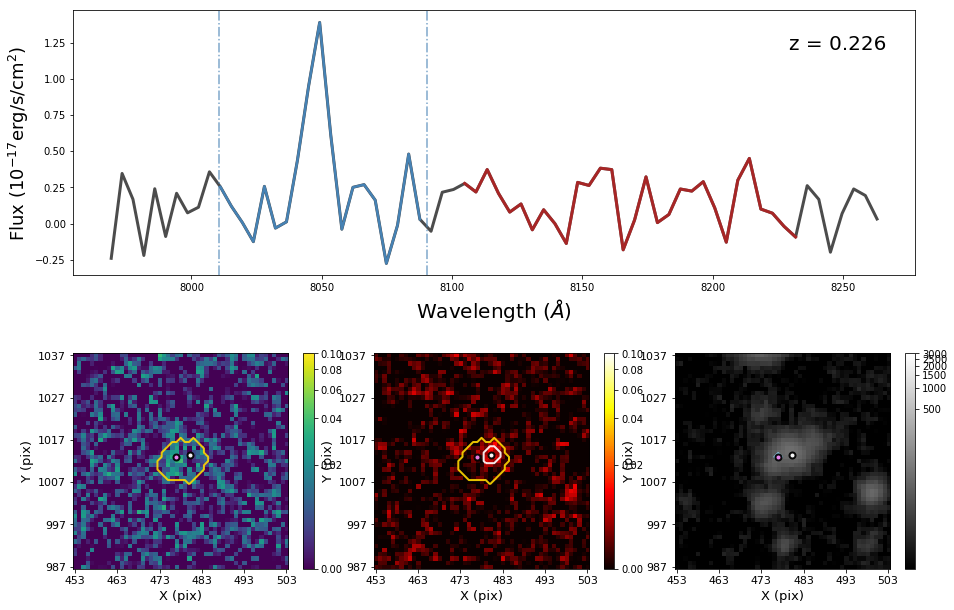

In [6]:
num = 1288
datacube.centroid_analysis(num, centroid_type="ISO-D",
                           sum_type="weighted", subtract_continuum=False, morph_cen=False)

stddev emission: 0.007 / continuum: 0.003
Centroid EM: (1589.63+/-0.06, 505.78+/-0.04)
Centroid CON: (1589.63+/-0.02, 504.54+/-0.01)


{'diff_angle': 168.15555736425216,
 'cen_offset': 1.240186053262375,
 'diff_angle_std': 2.8146099693035445,
 'cen_offset_std': 0.03595024818857183,
 'pa': 179.8936063744933,
 'clus_cen_angle': 348.04916373874545,
 'dist_clus_cen': 2352.044405440299}

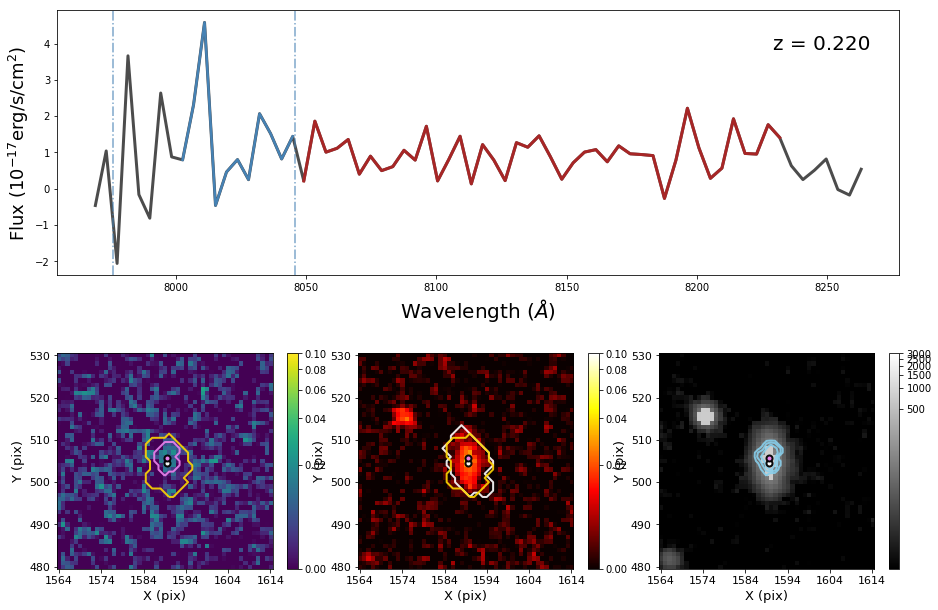

In [40]:
num = 351
datacube.centroid_analysis(num, centroid_type="ISO-D",
                           sum_type="mean", subtract_continuum=True, morph_cen=False)

stddev emission: 0.006 / continuum: 0.002
Centroid EM: (474.13+/-0.10, 1270.74+/-0.10)
Centroid CON: (474.56+/-0.11, 1271.05+/-0.11)


{'diff_angle': 8.591375197575985,
 'cen_offset': 0.5317901434716277,
 'diff_angle_std': 15.858739713711618,
 'cen_offset_std': 0.14719271714783594,
 'pa': 304.92930412846016,
 'clus_cen_angle': 313.52067932603615,
 'dist_clus_cen': 2205.9755121911876}

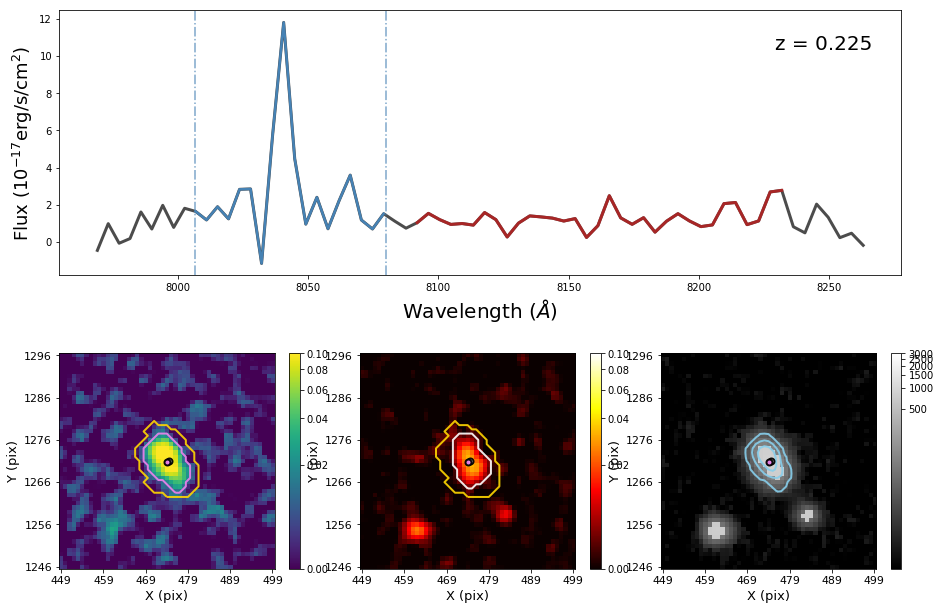

In [160]:
num = 1599
datacube.centroid_analysis(num, centroid_type="ISO-D", morph_cen=True,
                           sum_type="weighted", subtract_continuum=False, fwhm=2.8, smooth=True)

stddev emission: 0.013 / continuum: 0.003
Centroid EM: (473.39+/-0.16, 1271.63+/-0.16)
Centroid CON: (474.54+/-0.13, 1270.82+/-0.13)


{'diff_angle': 78.87677677665238,
 'cen_offset': 1.4044972668863314,
 'diff_angle_std': 8.384972821797893,
 'cen_offset_std': 0.20554169104972814,
 'pa': 234.6440818217112,
 'clus_cen_angle': 313.5208585983636,
 'dist_clus_cen': 2205.968335109961}

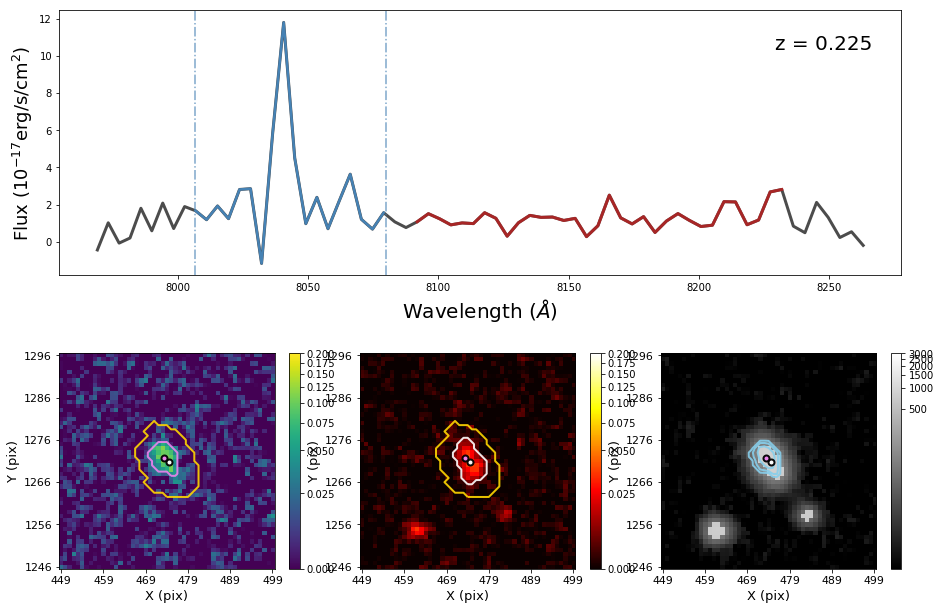

In [345]:
num = 846
datacube.centroid_analysis(num, centroid_type="ISO-D", morph_cen=True)

stddev emission: 0.006 / continuum: 0.002
Centroid EM: (538.44+/-0.00, 1566.49+/-0.00)
Centroid CON: (538.11+/-0.00, 1565.77+/-0.00)


{'diff_angle': 152.83261487226656,
 'cen_offset': 0.7904202667800821,
 'diff_angle_std': 0.14572796373839306,
 'cen_offset_std': 0.002281716423568364,
 'pa': 155.80480609868818,
 'clus_cen_angle': 308.63742097095474,
 'dist_clus_cen': 1959.4156835953886}

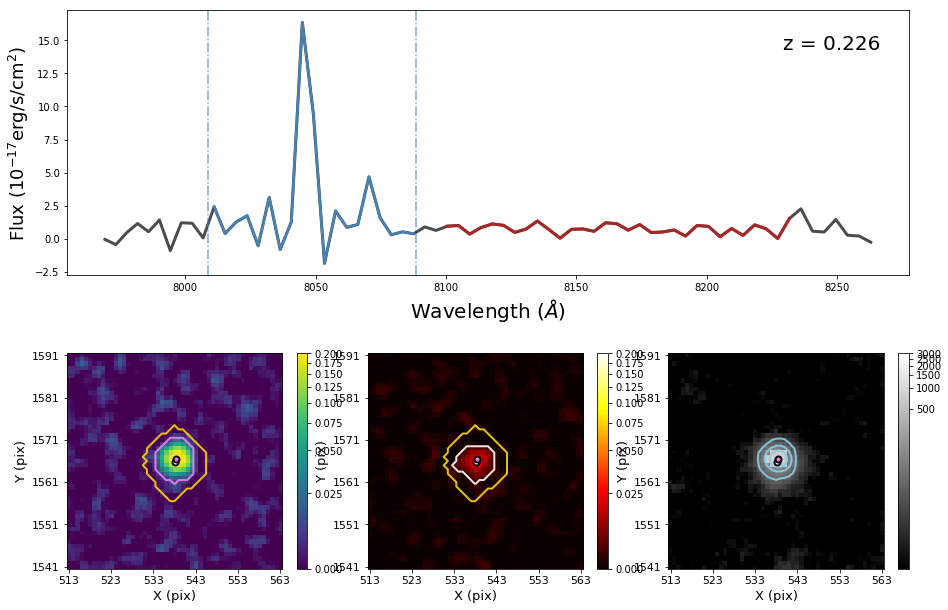

In [395]:
num = 1046
datacube.centroid_analysis(num, centroid_type="ISO-D", smooth=False)

In [92]:
# datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="APER")

In [53]:
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", 
                               sum_type='mean', morph_cen=False, verbose=False)
datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D",
                               sum_type='mean', morph_cen=True, verbose=False)

In [11]:
datacube.result_centroid.keys()

dict_keys(['ISO-D', 'ISO-Dm', 'ISO-Ds', 'ISO-Dms'])

In [45]:
datacube.save_centroid_measurement(Num_v_all, save_path='./proc/', suffix="_bgsub_mean", ID_field='E')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E_bgsub_mean.txt


In [54]:
datacube.save_centroid_measurement(Num_v_all, save_path='./proc/', suffix="_lpf_mean", ID_field='E')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E_lpf_mean.txt


In [11]:
# sn = 2
# for subtract in [True, False]:
#     subcon = 'subcon' if subtract else 'con'
#     for sum_type in ["mean", "weighted"]:

#     #     datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="APER", 
#     #                                    sum_type=sum_type, subtract=subtract, verbose=False)
#         datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", sn_thre=sn, 
#                                        sum_type=sum_type, subtract=subtract, morph_cen=False, verbose=False)
#         datacube.centroid_analysis_all(Num_v_all, nums_obj=Num_v_all, centroid_type="ISO-D", sn_thre=sn,
#                                        sum_type=sum_type, subtract=subtract, morph_cen=True,
#                                        fwhm=2.8, smooth=True, verbose=False)

#         datacube.save_centroid_measurement(Num_v_all, save_path='./proc/',
#                                            suffix="_lpf_%s_%s_sn%.1f"%(sum_type, subcon, sn), ID_field='E')

Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E_lpf_mean_subcon_sn2.0.txt


Save centroid measurement as catalog:  ./proc/centroid_analysis_A2390E_lpf_weighted_subcon_sn2.0.txt


In [16]:
# diff_angle_aper = datacube.get_centroid_result('diff_angle', 'APER', fill_value=0)
# cen_off_aper = datacube.get_centroid_result('cen_offset', 'APER', fill_value=0)
# cen_off_std_aper = datacube.get_centroid_result('cen_offset_std', 'APER', fill_value=99)

In [55]:
z_V =  datacube.get_CC_result_best('z_best', 'Ha-NII_gauss', Num_v_all)

diff_angle_iso_d = datacube.get_centroid_result('diff_angle', 'ISO-D', fill_value=0)
cen_off_iso_d = datacube.get_centroid_result('cen_offset', 'ISO-D', fill_value=0)
cen_off_std_iso_d = datacube.get_centroid_result('cen_offset_std', 'ISO-D', fill_value=99)

diff_angle_iso_dm = datacube.get_centroid_result('diff_angle', 'ISO-Dm', fill_value=0)
cen_off_iso_dm = datacube.get_centroid_result('cen_offset', 'ISO-Dm', fill_value=0)
cen_off_std_iso_dm = datacube.get_centroid_result('cen_offset_std', 'ISO-Dm', fill_value=99)

In [56]:
def condition_1(cen_off, cen_off_std, z_V):
    return (cen_off>1) & (cen_off>3*cen_off_std) & (abs(z_V-0.228)<0.015)

def condition_2(cen_off, cen_off_std, z_V):
    return (cen_off>1+3*cen_off_std) & (abs(z_V-0.228)<0.015)

cond = condition_1

# cond_a = cond(cen_off_aper, cen_off_std_aper, z_V)
cond_d = cond(cen_off_iso_d, cen_off_std_iso_d, z_V)
cond_dm = cond(cen_off_iso_dm, cen_off_std_iso_dm, z_V)

# d_angle_a1 = diff_angle_aper[cond_a]
d_angle_d1 = diff_angle_iso_d[cond_d]
d_angle_dm1 = diff_angle_iso_dm[cond_dm]

lpf

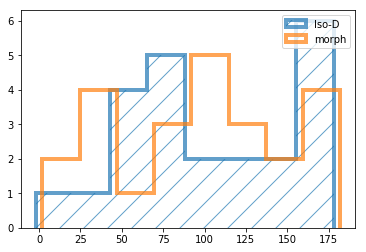

In [22]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1+2, bins=np.linspace(0,180,9)+2,histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

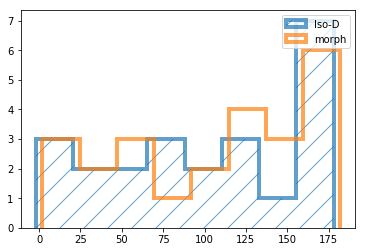

In [57]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1+2, bins=np.linspace(0,180,9)+2,histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

bg_sub

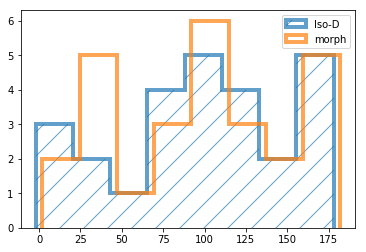

In [11]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1+2, bins=np.linspace(0,180,9)+2,histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

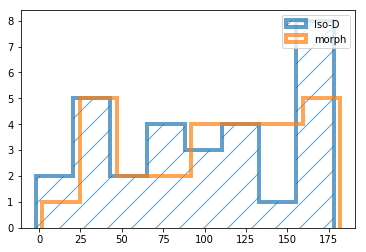

In [48]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1+2, bins=np.linspace(0,180,9)+2,histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

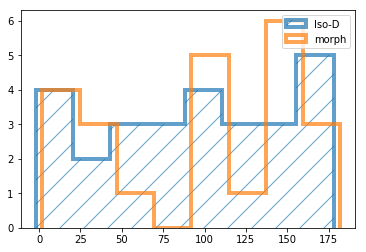

In [16]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1+2, bins=np.linspace(0,180,9)+2,histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

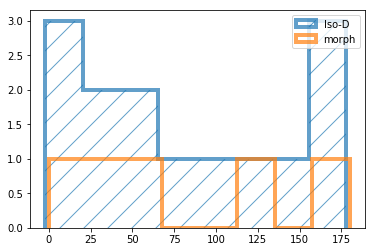

In [134]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,9)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,9),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

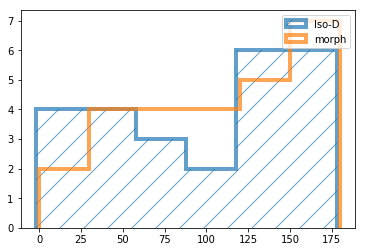

In [401]:
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()

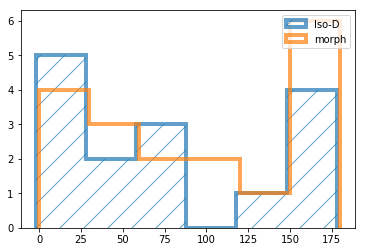

In [13]:
# plt.hist(d_angle_a1+2, bins=np.linspace(0,180,7)+2,histtype="step", hatch="/", lw=4, alpha=0.7,label='Aper')
plt.hist(d_angle_d1-2, bins=np.linspace(0,180,7)-2,histtype="step",hatch="/", lw=4, alpha=0.7,label='Iso-D')
plt.hist(d_angle_dm1, bins=np.linspace(0,180,7),histtype="step", lw=4, hatch="", alpha=0.7,label='morph')
plt.legend()